### 4. Где логистическая регрессия хороша и где не очень

#### Анализ отзывов IMDB к фильмам

Будем решать задачу бинарной классификации отзывов IMDB к фильмам. Имеется обучающая выборка с размеченными отзывами, по 12500 отзывов известно, что они хорошие, еще про 12500 – что они плохие. 

Здесь уже не так просто сразу приступить к машинному обучению, потому что готовой матрицы $X$ нет – ее надо приготовить. Будем использовать самый простой подход – мешок слов ("Bag of words"). При таком подходе признаками отзыва будут индикаторы наличия в нем каждого слова из всего корпуса, где корпус – это множество всех отзывов.

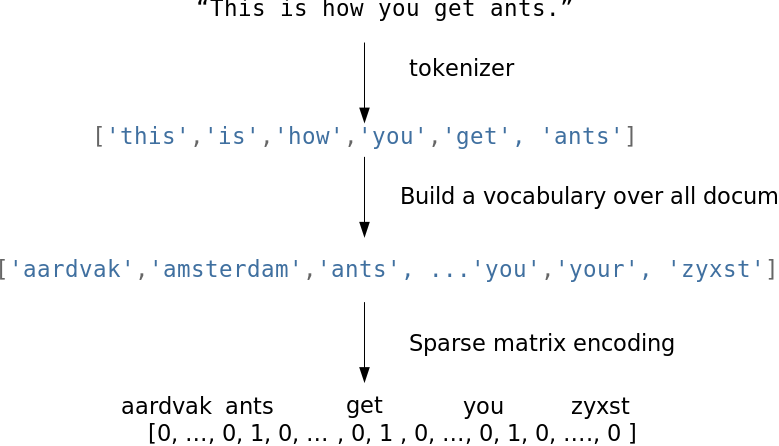

In [11]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import os

Загрузим данные

In [12]:
import tarfile
from io import BytesIO

import requests

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


def load_imdb_dataset(extract_path, overwrite=False):
    # check if existed already
    if (
        os.path.isfile(os.path.join(extract_path, "aclImdb", "README"))
        and not overwrite
    ):
        print("IMDB dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    tar = tarfile.open(mode="r:gz", fileobj=BytesIO(response.content))

    data = tar.extractall(extract_path)

In [13]:
DATA_PATH = "../../_static/data/"

load_imdb_dataset(extract_path=DATA_PATH)

IMDB dataset is already in place.


In [14]:
# change if you have it in alternative location
PATH_TO_IMDB = DATA_PATH + "aclImdb"

reviews_train = load_files(
    os.path.join(PATH_TO_IMDB, "train"), categories=["pos", "neg"]
)
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"), categories=["pos", "neg"])
text_test, y_test = reviews_test.data, reviews_test.target

In [32]:
#DATA_PATH_2 = "C:/Users/Us/Desktop/python_script/"
#PATH_TO_IMDB = DATA_PATH_2 + "aclImdb"

#reviews_train = load_files(
#    os.path.join(PATH_TO_IMDB, "train"), categories=["pos", "neg"]
#)
#text_train, y_train = reviews_train.data, reviews_train.target

#reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"), categories=["pos", "neg"])
#text_test, y_test = reviews_test.data, reviews_test.target

In [33]:
print("Number of documents in training data:", len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data:", len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам.

**Пример плохого отзыва:**

In [42]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [35]:
y_train[1]  # bad review

0

**Пример хорошего отзыва:**

In [36]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [37]:
y_train[2]  # good review

1

#### Простой подсчет слов

Составим словарь всех слов с помощью CountVectorizer. Всего в выборке 74849 уникальных слов.

In [18]:
cv = CountVectorizer()
cv.fit(text_train)

print(len(cv.vocabulary_)) #74849

74849


In [20]:
print(cv.get_feature_names_out()[:50])
print(cv.get_feature_names_out()[50000:50050])

['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02'
 '020410' '029' '03' '04' '041' '05' '050' '06' '06th' '07' '08' '087'
 '089' '08th' '09' '0f' '0ne' '0r' '0s' '10' '100' '1000' '1000000'
 '10000000000000' '1000lb' '1000s' '1001' '100b' '100k' '100m']
['pincher' 'pinchers' 'pinches' 'pinching' 'pinchot' 'pinciotti' 'pine'
 'pineal' 'pineapple' 'pineapples' 'pines' 'pinet' 'pinetrees' 'pineyro'
 'pinfall' 'pinfold' 'ping' 'pingo' 'pinhead' 'pinheads' 'pinho' 'pining'
 'pinjar' 'pink' 'pinkerton' 'pinkett' 'pinkie' 'pinkins' 'pinkish'
 'pinko' 'pinks' 'pinku' 'pinkus' 'pinky' 'pinnacle' 'pinnacles' 'pinned'
 'pinning' 'pinnings' 'pinnochio' 'pinnocioesque' 'pino' 'pinocchio'
 'pinochet' 'pinochets' 'pinoy' 'pinpoint' 'pinpoints' 'pins' 'pinsent']


In [41]:
# Закодируем предложения из текстов обучающей выборки индексами входящих слов. 
# Используем разреженный формат. 
# Преобразуем так же тестовую выборку.

X_train = cv.transform(text_train)
X_test = cv.transform(text_test)

Обучим логистическую регрессию и посмотрим на доли правильных ответов на обучающей и тестовой выборках.

In [43]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train, y_train)

print("Угадываем на обучающей выборке -", round(logit.score(X_train, y_train), 3))

Угадываем на обучающей выборке - 0.981
CPU times: total: 141 ms
Wall time: 5.46 s


In [44]:
print("Угадываем на тестовой выборке -", round(logit.score(X_test, y_test), 3))

Угадываем на тестовой выборке - 0.864


Получается, на тестовой выборке мы правильно угадываем тональность примерно 86.4% отзывов.

In [46]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

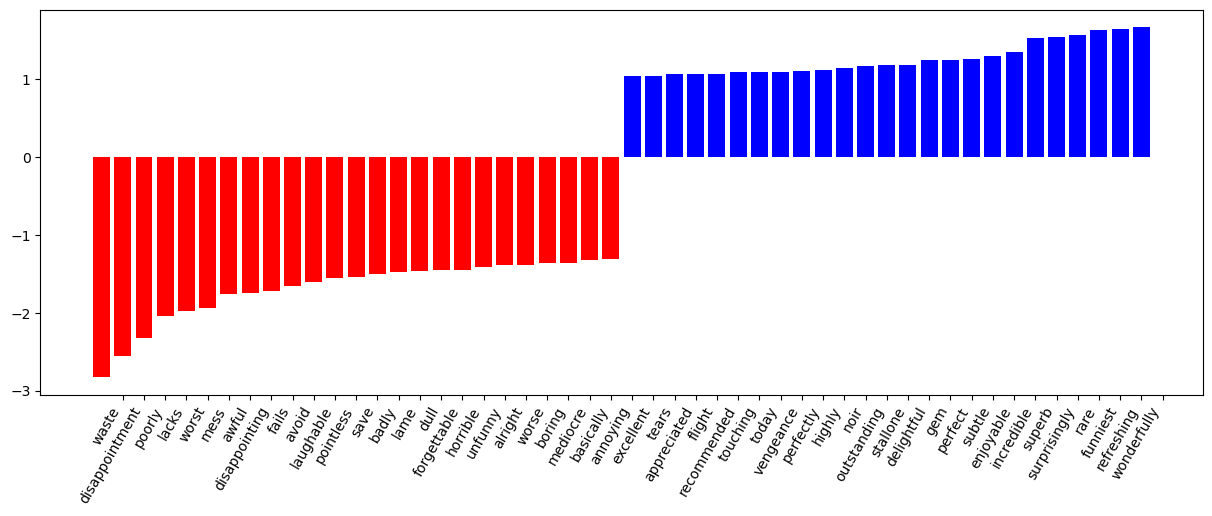

In [49]:
visualize_coefficients(logit, cv.get_feature_names_out())

Подберем коэффициент регуляризации для логистической регрессии. 

Используем **sklearn.pipeline**, поскольку CountVectorizer правильно применять только на тех данных, на которых в текущий момент обучается модель (чтоб не "подсматривать" в тестовую выборку и не считать по ней частоты вхождения слов). 

В данном случае pipeline задает последовательность действий: применить CountVectorizer, затем обучить логистическую регрессию. Так мы поднимаем долю правильных ответов до 88.5% на кросс-валидации и 87.9% – на отложенной выборке.

In [50]:
from sklearn.pipeline import make_pipeline

In [51]:
text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=17))

text_pipe_logit.fit(text_train, y_train)

print("Доля правильных ответов на обучающей выборке -", round(text_pipe_logit.score(text_train, y_train), 3))

Доля правильных ответов, используя pipeline - 0.981


In [52]:
print("Доля правильных ответов теста -", round(text_pipe_logit.score(text_test, y_test), 3))

Доля правильных ответов теста - 0.864


In [53]:
from sklearn.model_selection import GridSearchCV

In [61]:
param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(estimator=text_pipe_logit, param_grid=param_grid_logit, cv=3, n_jobs=-1, return_train_score=True)

grid_logit.fit(text_train, y_train)
grid_logit.best_params_

{'logisticregression__C': 0.1}

In [62]:
grid_logit.best_score_

0.8853999276361743

In [63]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
             color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
             color='red', label='test')
    plt.legend();

0.87812

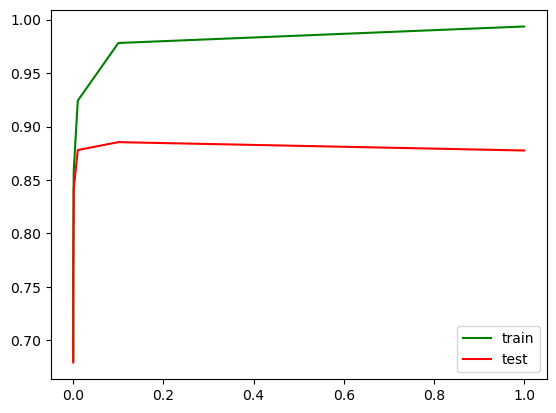

In [64]:
plot_grid_scores(grid_logit, 'logisticregression__C')
grid_logit.score(text_test, y_test)

In [65]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)
forest.fit(X_train, y_train)
print("Доля правильных ответов теста -", round(forest.score(X_test, y_test), 3))

Доля правильных ответов теста - 0.855


#### XOR-проблема

XOR — это логический оператор, работающий с битами. Давайте обозначим его ^. Если два получаемых им на входе бита одинаковы, то результат будет равен 0, в противном случае 1

При этом применяется операция исключающего ИЛИ — чтобы результат был равен 1, только один аргумент должен быть равен 1. Можно показать это с помощью таблицы истинности:

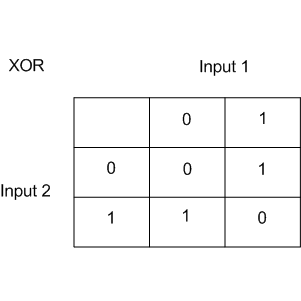

XOR дал имя простой задаче бинарной классификации, в которой классы представлены вытянутыми по диагоналям и пересекающимися облаками точек.


In [66]:
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

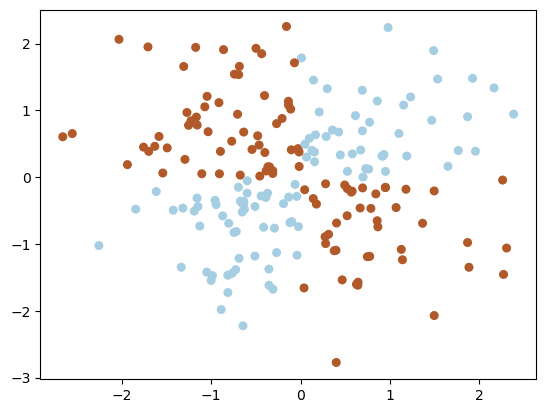

In [72]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)

In [73]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
    clf.fit(X, y)
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)
    image = plt.imshow(Z, interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
    linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$<!-- math>$inline$x_1$inline$</math -->$')
    plt.ylabel(r'$<!-- math>$inline$x_2$inline$</math -->$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);
    

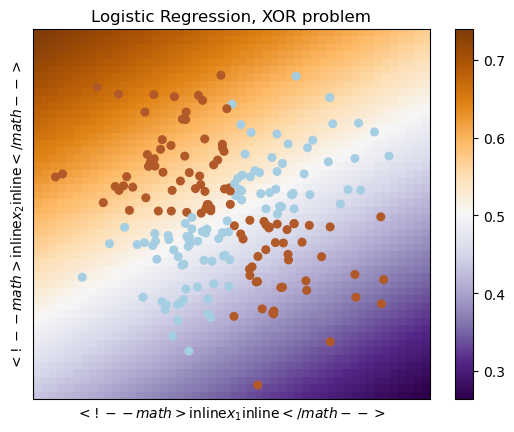

In [74]:
plot_boundary(LogisticRegression(), X, y, "Logistic Regression, XOR problem")

Очевидно, нельзя провести прямую так, чтобы без ошибок отделить один класс от другого. Поэтому логистическая регрессия плохо справляется с такой задачей.

А вот если на вход подать полиномиальные признаки, в данном случае до 2 степени, то проблема решается:

In [76]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [77]:
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), ('logit', LogisticRegression())])

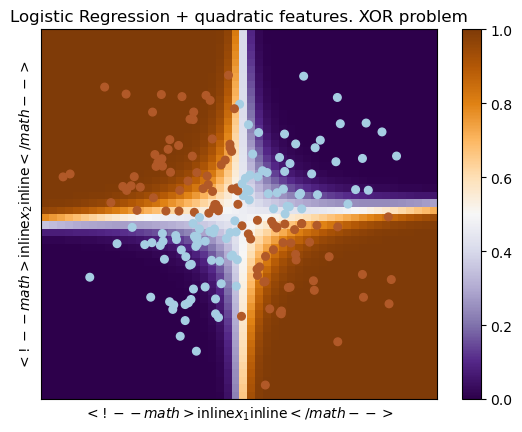

In [78]:
plot_boundary(logit_pipe, X, y, "Logistic Regression + quadratic features. XOR problem")

На практике полиномиальные признаки действительно помогают, но строить их явно – вычислительно неэффективно. Гораздо быстрее работает SVM с ядровым трюком. При таком подходе в пространстве высокой размерности считается только расстояние между объектами (задаваемое функцией-ядром), а явно плодить комбинаторно большое число признаков не приходится.

#### 5. Кривые валидации и обучения

Будем работать со знакомыми данными по оттоку клиентов телеком-оператора.

In [79]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve

In [80]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [83]:
data = pd.read_csv(DATA_PATH + "telecom_churn.csv").drop("State", axis=1)
data["International plan"] = data["International plan"].map({"Yes": 1, "No": 0})
data["Voice mail plan"] = data["Voice mail plan"].map({"Yes": 1, "No": 0})

y = data['Churn'].astype("int").values
X = data.drop('Churn', axis=1).values

In [84]:
y

array([0, 0, 0, ..., 0, 0, 0])

Логистическую регрессию будем обучать стохастическим градиентным спуском.

Построим валидационные кривые, показывающие, как качество (ROC AUC) на обучающей и проверочной выборке меняется с изменением параметра регуляризации.

In [100]:
alphas = np.logspace(-2, 0, 20)
sgd_logit = SGDClassifier(loss="log", n_jobs=-1, random_state=17, max_iter=5)
logit_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2)),
        ("sgd_logit", sgd_logit),
    ]
)
val_train, val_test = validation_curve(
    estimator=logit_pipe, X=X, y=y, param_name="sgd_logit__alpha", param_range=alphas, cv=5, scoring="roc_auc"
)

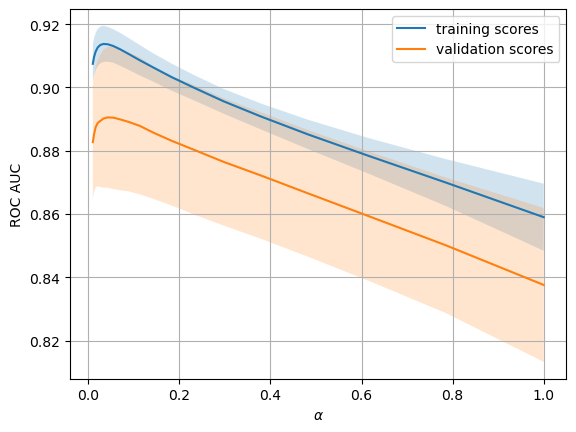

In [101]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )


plot_with_err(alphas, val_train, label="training scores")
plot_with_err(alphas, val_test, label="validation scores")
plt.xlabel(r"$\alpha$")
plt.ylabel("ROC AUC")
plt.legend()
plt.grid(True);

Тенденция видна сразу, и она очень часто встречается.



Для простых моделей тренировочная и валидационная ошибка находятся где-то рядом, и они велики. Это говорит о том, что моде**ль недообучилась: то есть она не имеет достаточное кол-во параметро



Для сильно усложненных моделей тренировочная и валидационная ошибки значительно отличаются. Это можно объяснить переобучением: когда параметров слишком много либо не хватает регуляризации, алгоритм может "отвлекаться" на шум в данных и упускать основной тренд.

#### Сколько нужно данных?

Идея простая: мы отображаем ошибку как функцию от количества примеров, используемых для обучения. При этом параметры модели фиксируются заранее.

Давайте посмотрим, что мы получим для линейной модели. Коэффициент регуляризации выставим большим.

In [104]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree=2, alpha=0.01):
    train_sizes = np.linspace(0.05, 1, 20)
    logit_pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=degree)),
            (
                "sgd_logit",
                SGDClassifier(n_jobs=-1, random_state=17, alpha=alpha, max_iter=5),
            ),
        ]
    )
    N_train, val_train, val_test = learning_curve(
        logit_pipe, X, y, train_sizes=train_sizes, cv=5, scoring="roc_auc"
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True);

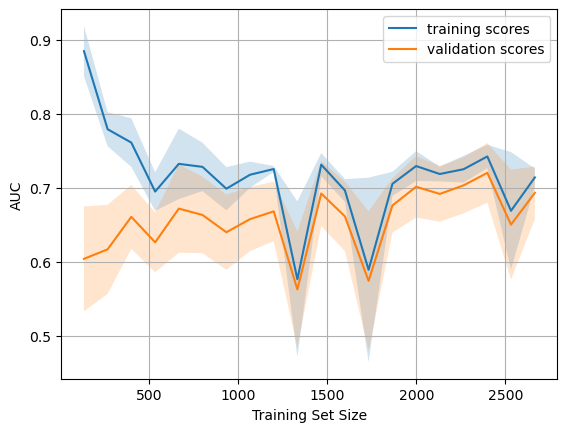

In [105]:
plot_learning_curve(degree=2, alpha=10)

Типичная ситуация: для небольшого объема данных ошибки на обучающей выборке и в процессе кросс-валидации довольно сильно отличаются, что указывает на переобучение. Для той же модели, но с большим объемом данных ошибки "сходятся", что указывается на недообучение.

Если добавить еще данные, ошибка на обучающей выборке не будет расти, но с другой стороны, ошибка на тестовых данных не будет уменьшаться.

Получается, ошибки "сошлись", и добавление новых данных не поможет. Собственно, это случай – самый интересный для бизнеса. Возможна ситуация, когда мы увеличиваем выборку в 10 раз. Но если не менять сложность модели, это может и не помочь. То есть стратегия "настроил один раз – дальше использую 10 раз" может и не работать.

Что будет, если изменить коэффициент регуляризации (уменьшить до 0.05)?


Видим хорошую тенденцию – кривые постепенно сходятся, и если дальше двигаться направо (добавлять в модель данные), можно еще повысить качество на валидации.

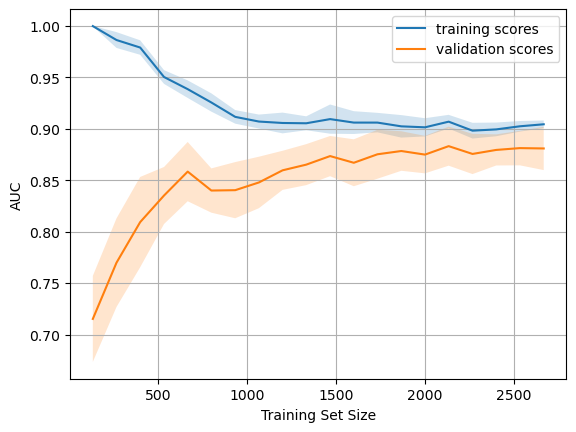

In [106]:
plot_learning_curve(degree=2, alpha=0.05)

А если усложнить модель ещё больше ($alpha=10^{-4}$)?

Проявляется переобучение – AUC падает как на обучении, так и на валидации.

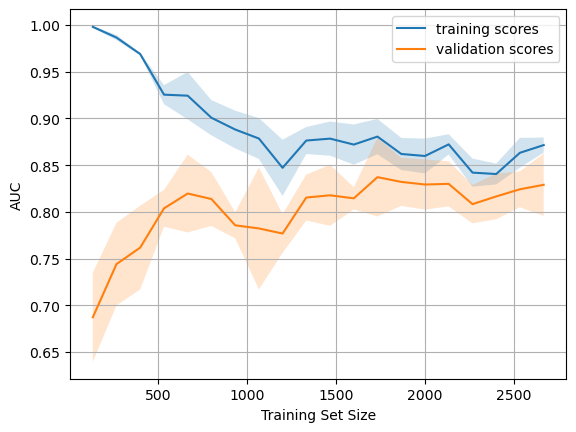

In [108]:
plot_learning_curve(degree=2, alpha=1e-4)

#### Выводы по кривым валидации и обучения

1) Ошибка на обучающей выборке сама по себе ничего не говорит о качестве модели

2) Кросс-валидационная ошибка показывает, насколько хорошо модель подстраивается под данные (имеющийся тренд в данных), сохраняя при этом способность обобщения на новые данные

3) Валидационная кривая представляет собой график, показывающий результат на тренировочной и валидационной выборке в зависимости от сложности модели:

    3.1. если две кривые распологаются близко, и обе ошибки велики, — это признак недообучения

    3.2. если две кривые далеко друг от друга, — это показатель переобучения

4) Кривая обучения — это график, показывающий результаты на валидации и тренировочной подвыборке в зависимости от количества наблюдений:

    4.1. если кривые сошлись друг к другу, добавление новых данных не поможет – надо менять сложность модели

    4.2. если кривые еще не сошлись, добавление новых данных может улучшить результат.


#### 6. Плюсы и минусы линейных моделей в задачах машинного обучения

Плюсы:

1) Хорошо изучены

2) Очень быстрые, могут работать на очень больших выборках

3) Практически вне конкуренции, когда признаков очень много (от сотен тысяч и более), и они разреженные (хотя есть еще факторизационные машины)

4) Коэффициенты перед признаками могут интерпретироваться (при условии что признаки масштабированы) – в линейной регрессии как частные производные зависимой переменной от признаков, в логистической – как изменение шансов на отнесение к одному из классов в $\exp^{\beta_i}$ раз при изменении признака $x_i$ на 1 ед., подробнее тут

5) Логистическая регрессия выдает вероятности отнесения к разным классам (это очень ценится, например, в кредитном скоринге)

6) Модель может строить и нелинейную границу, если на вход подать полиномиальные признаки


Минусы:

1) Плохо работают в задачах, в которых зависимость ответов от признаков сложная, нелинейная

2) На практике предположения теоремы Маркова-Гаусса почти никогда не выполняются, поэтому чаще линейные методы работают хуже, чем, например, SVM и ансамбли (по качеству решения задачи классификации/регрессии)